Let the RK45 solver decide how many points we should have and then, evaluate the solution

In [1]:
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, lstsq, norm
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model

In [2]:
#some most useful functions for data generations are now in scripts/mechanisms.py 
import sys
sys.path.insert(1, 'scripts/')
import scripts.mechanisms as mechanisms
import scripts.ls_solvers as solvers

In [3]:
plt.style.use('default')
#plt.rcParams["figure.figsize"] = (15,10)
#plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams.update({'font.size': 19})

In [4]:
constants = [1, 1, 1, 0]

In [5]:
k1, k_1, k2, k_2 = constants
W0 = np.array([[0, 0, 0, k_1, 0, -k1, 0,    0, 0, 0,  0,    0, 0, 0  ],
               [0, 0, 0, k2,      0, 0,   -k_2, 0, 0, 0,  0,    0, 0, 0 ],
               [0, 0, 0, k2+k_1,  0, -k1, -k_2, 0, 0, 0, 0,    0, 0, 0  ],
               [0, 0, 0, -k2-k_1, 0,  k1,  k_2, 0, 0, 0, 0,    0, 0, 0  ]])
W0.shape

(4, 14)

In [6]:
#initial values
U0 = np.array([1.0, 0.0, 0.1, 0.0])
# U0 = np.vstack((U0, [1.0, 0.0, 0.15, 0.0]))
# U0 = np.vstack((U0, [1.0, 0.0, 0.05, 0.0]))

In [7]:
#U0.shape

In [8]:
# if we have only one initial condition
U0 = U0.reshape((1,4))

In [9]:
integration = 'RK45'
differentiation = 'spline'
npts = 87
tmax = 100
t_eval = np.linspace(0,tmax,npts) 
rtol = 1e-6


In [10]:
X, T, Y = mechanisms.find_solutions(U0, constants, 'A1r', differentiation, 100, rtol, integration, t_eval) # checked fine

RK45


In [11]:
X.shape

(87, 4)

Text(0.5, 1.0, 'Species Concentrations $X$ for $k_1 = 1$, $k_{-1} = 1$, $k_2 = 1$, $k_{-2} = 0$')

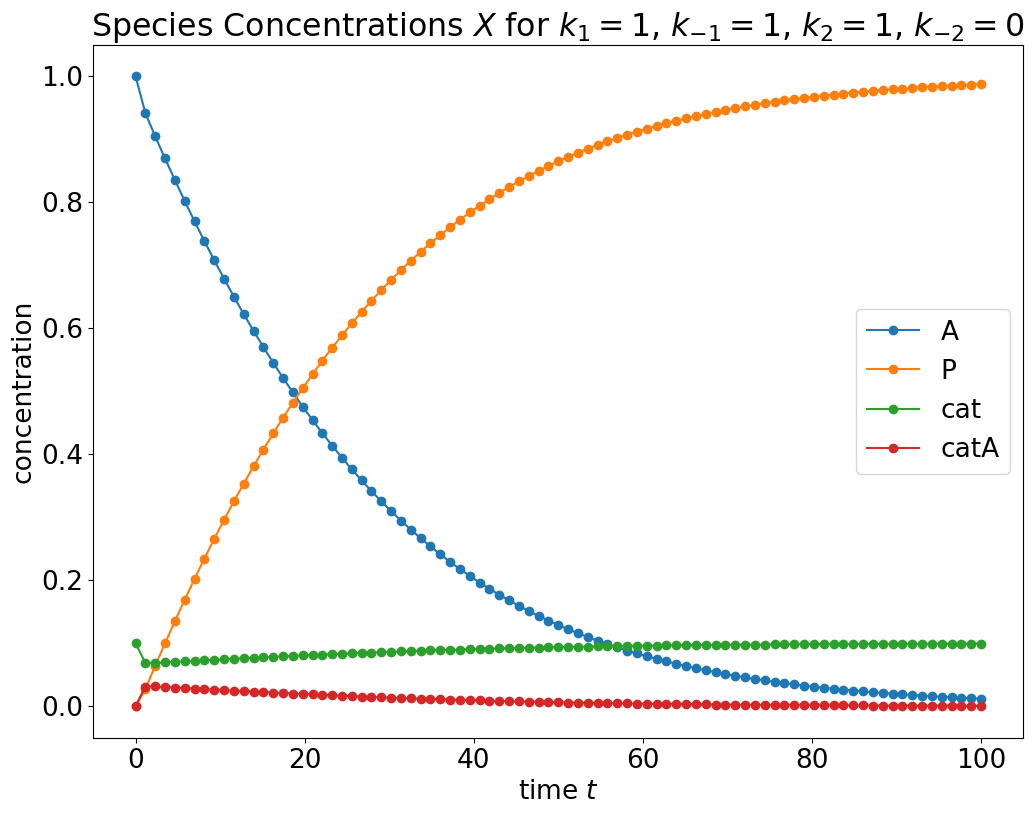

In [12]:
mechanisms.plot_concentrations(T, X, 'A1r')
plt.title('Species Concentrations $X$ for $k_1 = 1$, $k_{-1} = 1$, $k_2 = 1$, $k_{-2} = 0$')

In [13]:
Y_gt = mechanisms.ode(T, X.T, constants, 'A1r').T

In [14]:
Y_gt.shape

(87, 4)

In [15]:
mechanisms.get_residual(Y, Y_gt)

absolute residual 0.07880483554758842
relative residual 0.38961725127076324


(0.07880483554758842, 0.38961725127076324)

Text(0.5, 1.0, 'Spline Approximation at Equispaced Points')

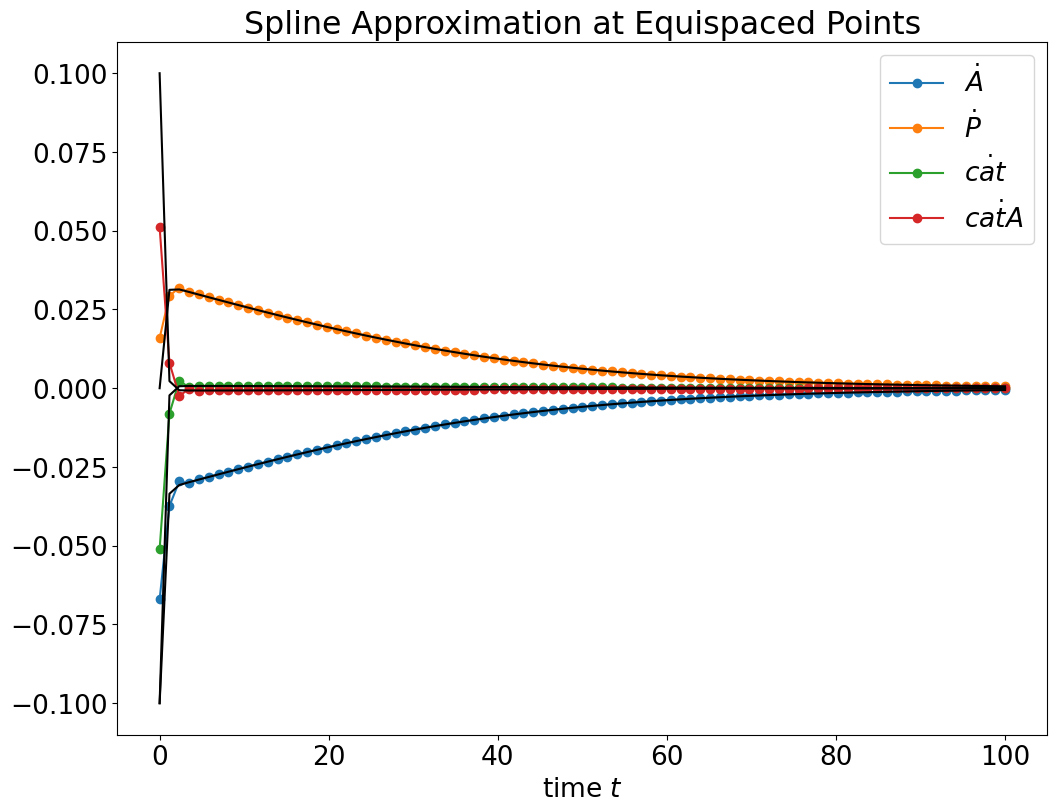

In [16]:
mechanisms.plot_derivatives(T, Y, 'A1r')
plt.plot(T, Y_gt, '-k')
plt.title('Spline Approximation at Equispaced Points')

<function matplotlib.pyplot.show(*args, **kw)>

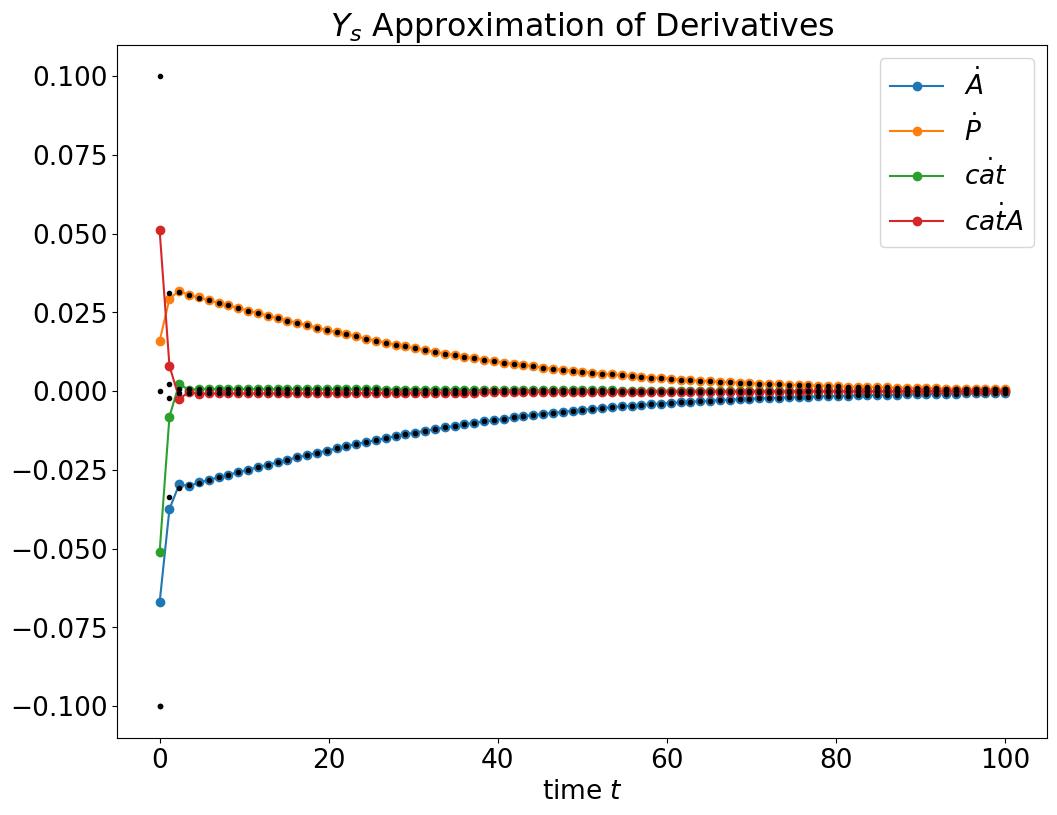

In [17]:
mechanisms.plot_derivatives(T, Y, 'A1r')
plt.plot(T, Y_gt, ".k")
plt.title('$Y_{s}$ Approximation of Derivatives')
plt.show

In [18]:
mechanisms.get_residual(Y, Y_gt)

absolute residual 0.07880483554758842
relative residual 0.38961725127076324


(0.07880483554758842, 0.38961725127076324)

## Basic LS solver 

Our first test is to solve the above least squares problem as is, that is, without any regularisation or sparsity promoting terms. Note that minimizing the Frobenius norm over matrices in this problem is the same as solving $d$ ordinary least squares problem for each column of $Y$ and $Y'$. So we can just solve them one after another to get the coefficients for each of the $d$ equations.

As can be seen, this leads to a dense solution (all coeffs are nonzero). We can also check the relative residual of the solution to get some idea about the noise level. Note the residual is relatively large (close to 1 percent) and I think this is due to the numerical differentiation.

Creating $[n\times m]$ features matrix $\widetilde{X}$ 

In [19]:
t_eq = np.linspace(0,99,npts) 

In [20]:
X_tilde, labels = mechanisms.get_features(X, 'A1r', square=True)

added squared terms
X_tilde features matrix shape:  (87, 14)
labels:  ['A', 'P', 'cat', 'catA', 'P*A', 'cat*A', 'cat*P', 'catA*A', 'catA*P', 'catA*cat', 'A*A', 'P*P', 'cat*cat', 'catA*catA']


In [21]:
rtol=1e-10

In [22]:
W_lsq = solvers.lsq(X_tilde, Y)


equation #0
relative residual 0.008879229975864229
coefficients [ -4.27275502  -2.06761866 -22.27929132  24.05028216   6.90914487
  15.2010704   11.45333475 -15.6283459  -11.66009662 -48.93369647
   4.44644602   2.68333309  46.70576734  51.33872469]

equation #1
relative residual 0.004857040622260578
coefficients [ -2.09916112  -0.93835025 -11.0354502   11.92411007   3.39185478
   7.51841414   5.49896259  -7.72833025  -5.59279761 -24.05282693
   2.23731435   1.26259258  22.94928191  25.24523794]

equation #2
relative residual 0.035756537679436
coefficients [ -6.37191613  -3.00596891 -33.31474152  35.97439224  10.30099965
  22.71948454  16.95229734 -23.35667615 -17.25289423 -72.9865234
   6.68376037   3.94592567  69.65504925  76.58396262]

equation #3
relative residual 0.035756537679407084
coefficients [  6.37191613   3.00596891  33.31474152 -35.97439224 -10.30099965
 -22.71948454 -16.95229734  23.35667615  17.25289423  72.9865234
  -6.68376037  -3.94592567 -69.65504925 -76.58396262]


In [23]:
s = mechanisms.print_equation(labels, W_lsq, 1e-6)
equations = mechanisms.string_equation(labels, W_lsq, 1e-6) 
X_lsq, T_lsq, Y_lsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, 100, rtol, integration, t_eq)

-4.27[A]-2.07[P]-22.28[cat]+24.05[catA]+6.91[P*A]+15.20[cat*A]+11.45[cat*P]-15.63[catA*A]-11.66[catA*P]-48.93[catA*cat]+4.45[A*A]+2.68[P*P]+46.71[cat*cat]+51.34[catA*catA]
______
-2.10[A]-0.94[P]-11.04[cat]+11.92[catA]+3.39[P*A]+7.52[cat*A]+5.50[cat*P]-7.73[catA*A]-5.59[catA*P]-24.05[catA*cat]+2.24[A*A]+1.26[P*P]+22.95[cat*cat]+25.25[catA*catA]
______
-6.37[A]-3.01[P]-33.31[cat]+35.97[catA]+10.30[P*A]+22.72[cat*A]+16.95[cat*P]-23.36[catA*A]-17.25[catA*P]-72.99[catA*cat]+6.68[A*A]+3.95[P*P]+69.66[cat*cat]+76.58[catA*catA]
______
+6.37[A]+3.01[P]+33.31[cat]-35.97[catA]-10.30[P*A]-22.72[cat*A]-16.95[cat*P]+23.36[catA*A]+17.25[catA*P]+72.99[catA*cat]-6.68[A*A]-3.95[P*P]-69.66[cat*cat]-76.58[catA*catA]
______
sparsity: 56
-4.272755016955567*A-2.067618658111728*P-22.279291315398886*cat+24.0502821644024*catA+6.909144868794831*P*A+15.201070400920417*cat*A+11.453334753705196*cat*P-15.628345902632786*catA*A-11.66009661922606*catA*P-48.93369646980183*catA*cat+4.446446016685994*A*A+2.6833330934447

now knowing the equations we find the solutions for equispaced points

In [24]:
npts = T.shape[0]
npts

87

In [25]:
tmax = T[-1]

In [26]:
Y_lsq.shape

(87, 4)

In [27]:
_, er_y = mechanisms.get_residual(Y_lsq, Y)
_, er_gt = mechanisms.get_residual(Y_lsq, Y_gt)
_, er_x = mechanisms.get_residual(X_lsq, X)
_, er_w = mechanisms.get_residual(W_lsq, W0)

table = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['basic least squares'])

absolute residual 0.0793903413786724
relative residual 0.32163352247929106
absolute residual 0.004223923263327477
relative residual 0.017112350120605524
absolute residual 0.03515345176846186
relative residual 0.004306040034257802
absolute residual 227.441724516893
relative residual 0.9978278500317554


In [28]:
table

,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.321634,0.017112,0.004306,0.997828,56


In [29]:
T.shape

(87,)

## Sequential Thresholded Least Squares

In [30]:
alpha = 0.5
W_stlsq = solvers.stlsq(X_tilde, Y, alpha)   
s = mechanisms.print_equation(labels, W_stlsq, 1e-2)
equations = mechanisms.string_equation(labels, W_stlsq, 1e-5)
X_stlsq, T_stlsq, Y_stlsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, t_eq)

-4.27[A]-2.07[P]-22.28[cat]+24.05[catA]+6.91[P*A]+15.20[cat*A]+11.45[cat*P]-15.63[catA*A]-11.66[catA*P]-48.93[catA*cat]+4.45[A*A]+2.68[P*P]+46.71[cat*cat]+51.34[catA*catA]
______
-2.10[A]-0.94[P]-11.04[cat]+11.92[catA]+3.39[P*A]+7.52[cat*A]+5.50[cat*P]-7.73[catA*A]-5.59[catA*P]-24.05[catA*cat]+2.24[A*A]+1.26[P*P]+22.95[cat*cat]+25.25[catA*catA]
______
-6.37[A]-3.01[P]-33.31[cat]+35.97[catA]+10.30[P*A]+22.72[cat*A]+16.95[cat*P]-23.36[catA*A]-17.25[catA*P]-72.99[catA*cat]+6.68[A*A]+3.95[P*P]+69.66[cat*cat]+76.58[catA*catA]
______
+6.37[A]+3.01[P]+33.31[cat]-35.97[catA]-10.30[P*A]-22.72[cat*A]-16.95[cat*P]+23.36[catA*A]+17.25[catA*P]+72.99[catA*cat]-6.68[A*A]-3.95[P*P]-69.66[cat*cat]-76.58[catA*catA]
______
sparsity: 56
-4.272755016955567*A-2.067618658111728*P-22.279291315398886*cat+24.0502821644024*catA+6.909144868794831*P*A+15.201070400920417*cat*A+11.453334753705196*cat*P-15.628345902632786*catA*A-11.66009661922606*catA*P-48.93369646980183*catA*cat+4.446446016685994*A*A+2.6833330934447

In [31]:
X_stlsq.shape

(87, 4)

In [32]:
_, er_y = mechanisms.get_residual(Y_stlsq, Y)
_, er_gt = mechanisms.get_residual(Y_stlsq, Y_gt)
_, er_x = mechanisms.get_residual(X_stlsq, X)
_, er_w = mechanisms.get_residual(W_stlsq, W0)

row =  pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['STLSQ ' +  '$\alpha$' + '=' + str(alpha)])
table = table.append(row)
table

absolute residual 0.0793903413786724
relative residual 0.32163352247929106
absolute residual 0.004223923263327477
relative residual 0.017112350120605524
absolute residual 0.03515345176846186
relative residual 0.004306040034257802
absolute residual 227.441724516893
relative residual 0.9978278500317554


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.321634,0.017112,0.004306,0.997828,56
STLSQ $lpha$=0.5,0.321634,0.017112,0.004306,0.997828,56


In [33]:
alpha = 0.4
W_stlsq = solvers.stlsq(X_tilde, Y, alpha)   
s = mechanisms.print_equation(labels, W_stlsq, 1e-2)
equations = mechanisms.string_equation(labels, W_stlsq, 1e-5)
X_stlsq, T_stlsq, Y_stlsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, 100, rtol, integration, t_eq)
_, er_y = mechanisms.get_residual(Y_stlsq, Y)
_, er_gt = mechanisms.get_residual(Y_stlsq, Y_gt)
_, er_x = mechanisms.get_residual(X_stlsq, X)
_, er_w = mechanisms.get_residual(W_stlsq, W0)

row =  pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['STLSQ, $\alpha$ = ' + str(alpha)])
table = table.append(row)
table

-4.27[A]-2.07[P]-22.28[cat]+24.05[catA]+6.91[P*A]+15.20[cat*A]+11.45[cat*P]-15.63[catA*A]-11.66[catA*P]-48.93[catA*cat]+4.45[A*A]+2.68[P*P]+46.71[cat*cat]+51.34[catA*catA]
______
-2.10[A]-0.94[P]-11.04[cat]+11.92[catA]+3.39[P*A]+7.52[cat*A]+5.50[cat*P]-7.73[catA*A]-5.59[catA*P]-24.05[catA*cat]+2.24[A*A]+1.26[P*P]+22.95[cat*cat]+25.25[catA*catA]
______
-6.37[A]-3.01[P]-33.31[cat]+35.97[catA]+10.30[P*A]+22.72[cat*A]+16.95[cat*P]-23.36[catA*A]-17.25[catA*P]-72.99[catA*cat]+6.68[A*A]+3.95[P*P]+69.66[cat*cat]+76.58[catA*catA]
______
+6.37[A]+3.01[P]+33.31[cat]-35.97[catA]-10.30[P*A]-22.72[cat*A]-16.95[cat*P]+23.36[catA*A]+17.25[catA*P]+72.99[catA*cat]-6.68[A*A]-3.95[P*P]-69.66[cat*cat]-76.58[catA*catA]
______
sparsity: 56
-4.272755016955567*A-2.067618658111728*P-22.279291315398886*cat+24.0502821644024*catA+6.909144868794831*P*A+15.201070400920417*cat*A+11.453334753705196*cat*P-15.628345902632786*catA*A-11.66009661922606*catA*P-48.93369646980183*catA*cat+4.446446016685994*A*A+2.6833330934447

,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.321634,0.017112,0.004306,0.997828,56
STLSQ $lpha$=0.5,0.321634,0.017112,0.004306,0.997828,56
"STLSQ, $lpha$ = 0.4",0.321634,0.017112,0.004306,0.997828,56


In [34]:
# mechanisms.print_equation(labels, W_stlsq, 1e-5)

In [35]:
alphas = np.linspace(0.0, 10, 200)
W_stlsq_arr = []
for alpha in alphas: 
    w = solvers.stlsq(X_tilde, Y, alpha)  
    W_stlsq_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]}$ using STLSQ')

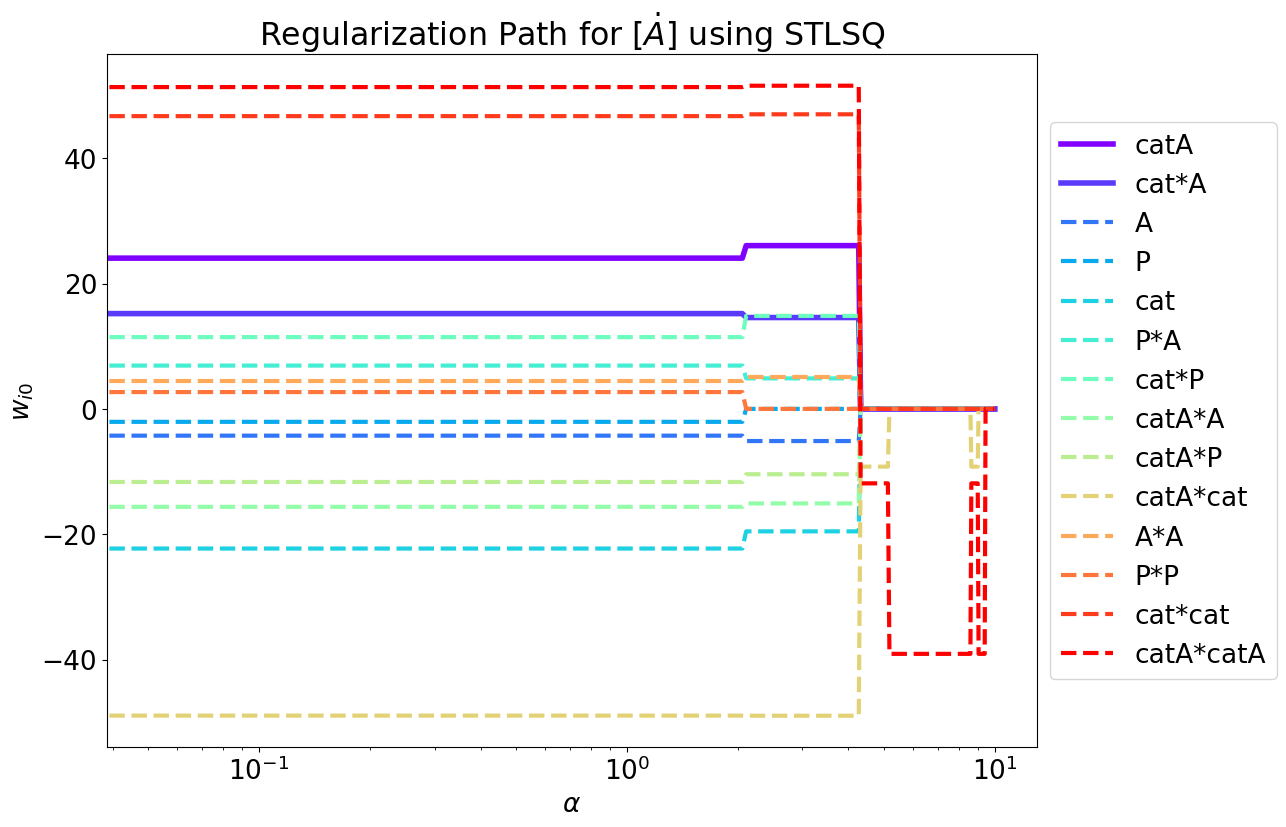

In [36]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]}$ using STLSQ")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]}$ using STLSQ')

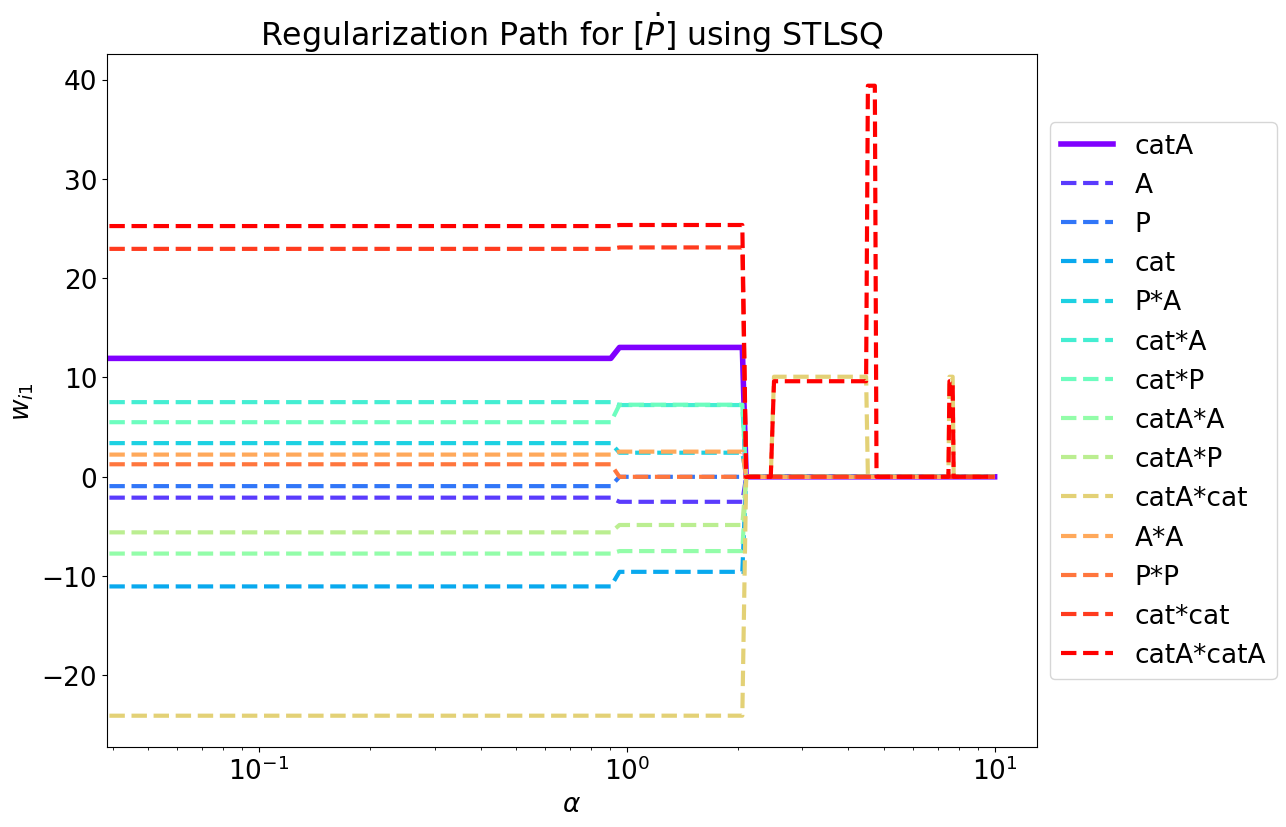

In [37]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]}$ using STLSQ")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ using STLSQ')

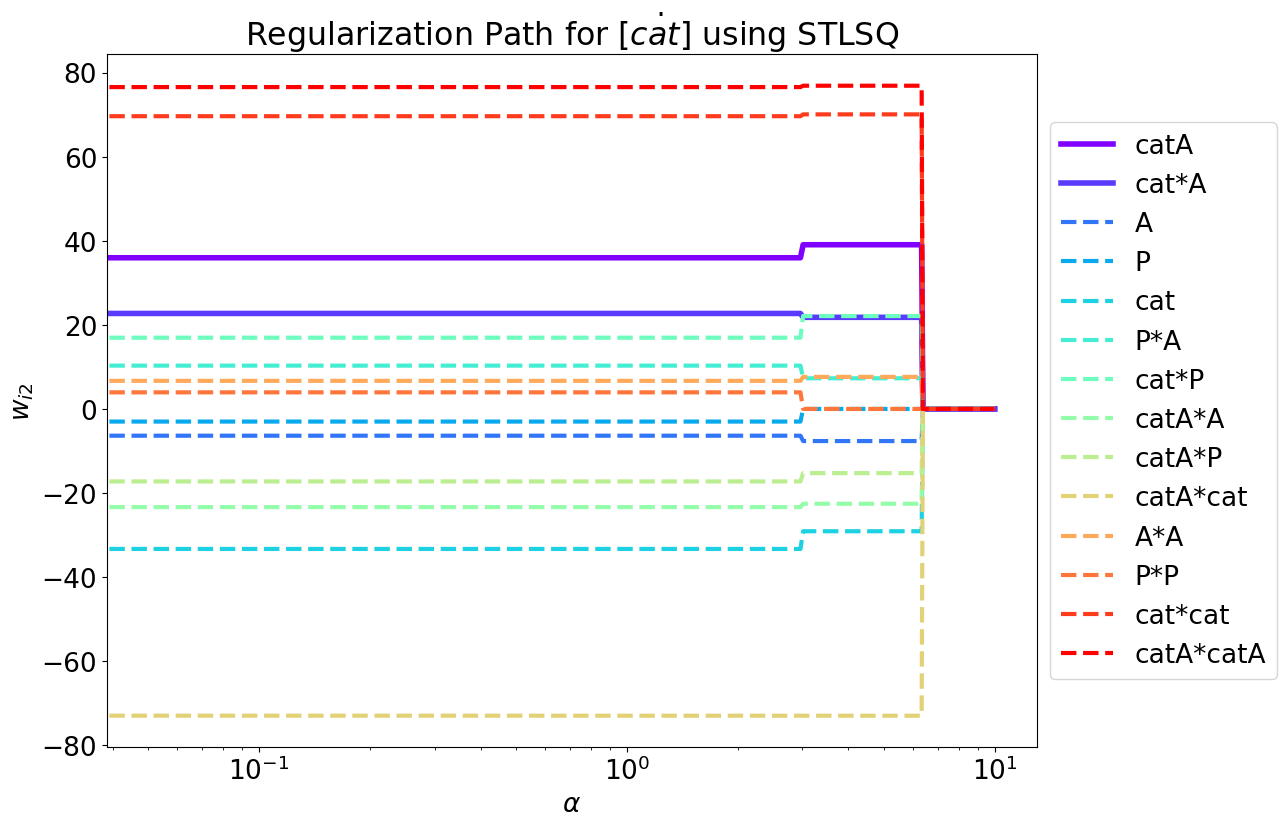

In [38]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ using STLSQ")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ using STLSQ')

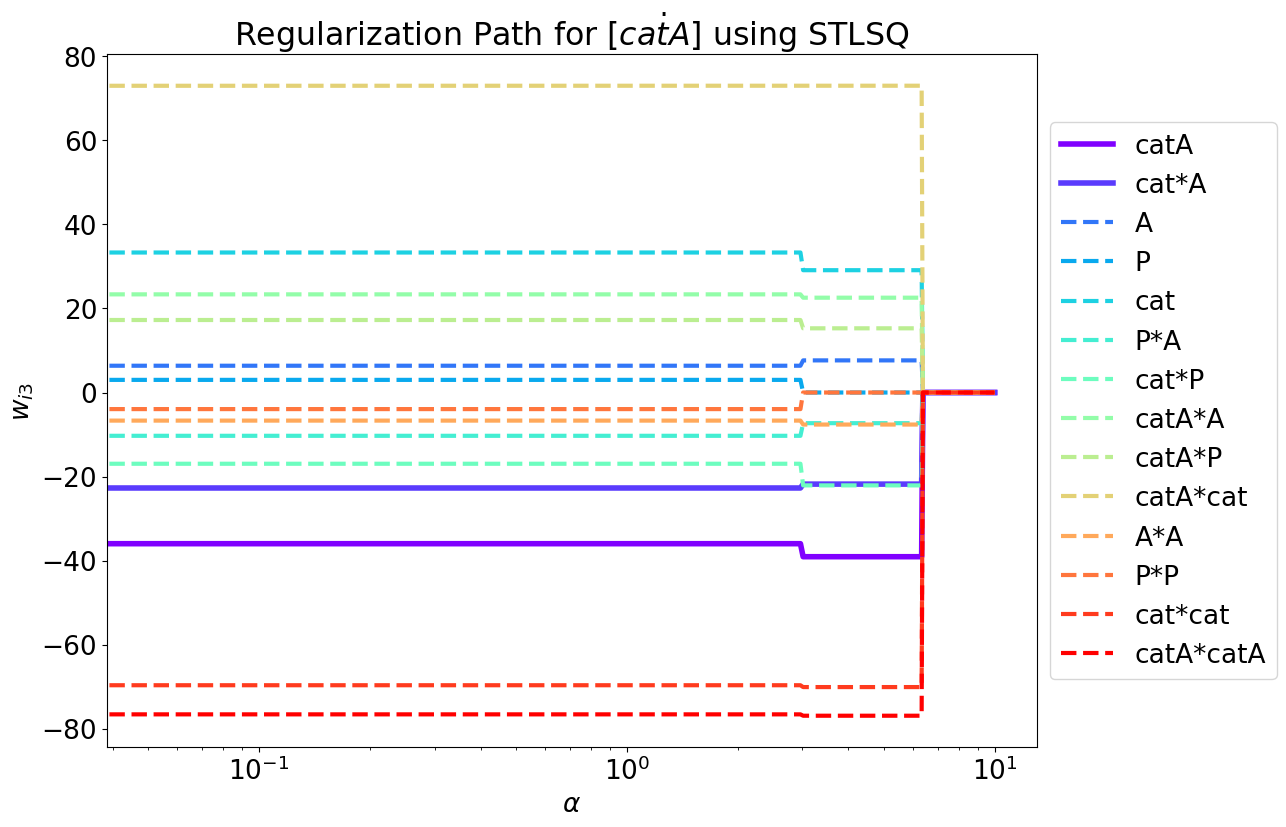

In [39]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ using STLSQ")

# Lasso CVXPY


In [40]:
lambdas = np.logspace(-5, 0, 10)
W_lasso_arr = []
for lambd in lambdas: 
    w = solvers.lasso_cvxp(X_tilde, Y, lambd)  
    W_lasso_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ using Lasso')

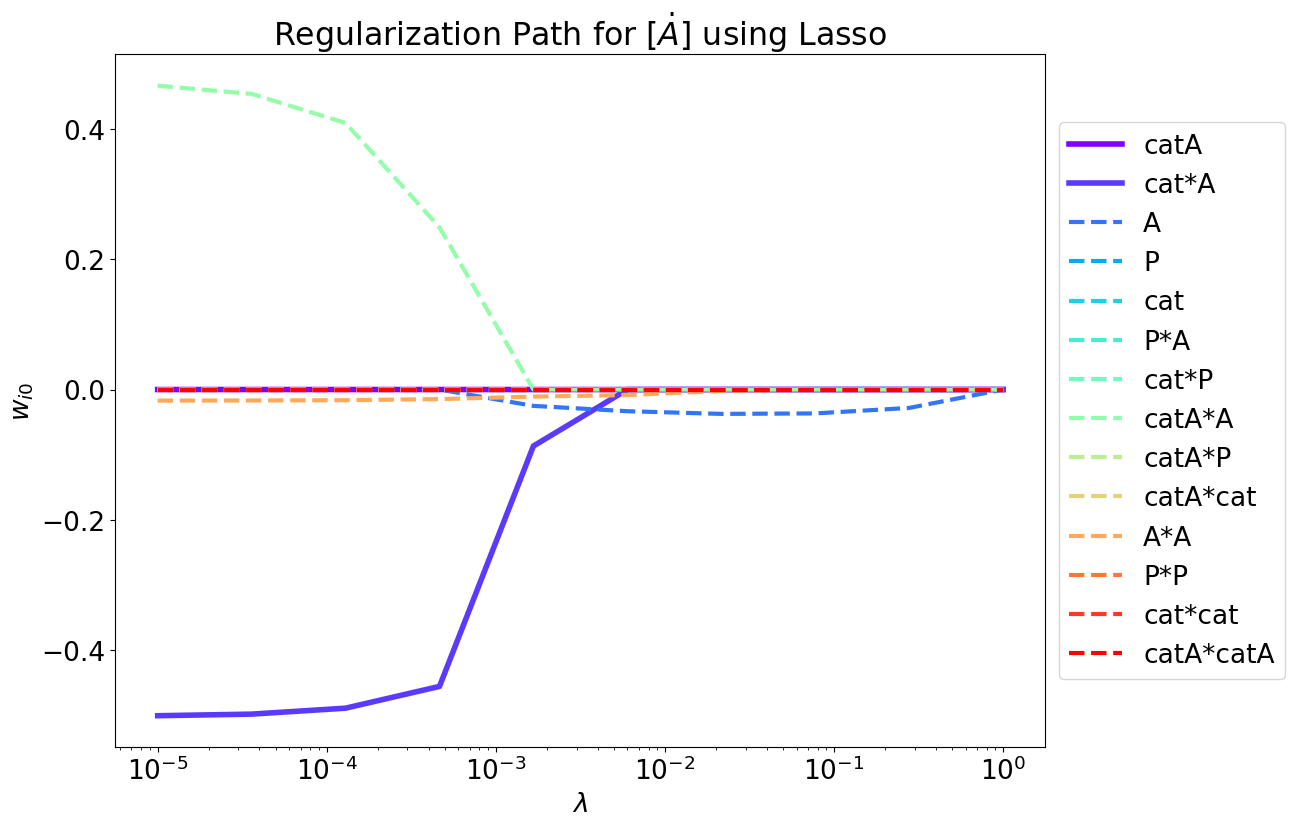

In [41]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 0, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{A}]$ using Lasso")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ using Lasso')

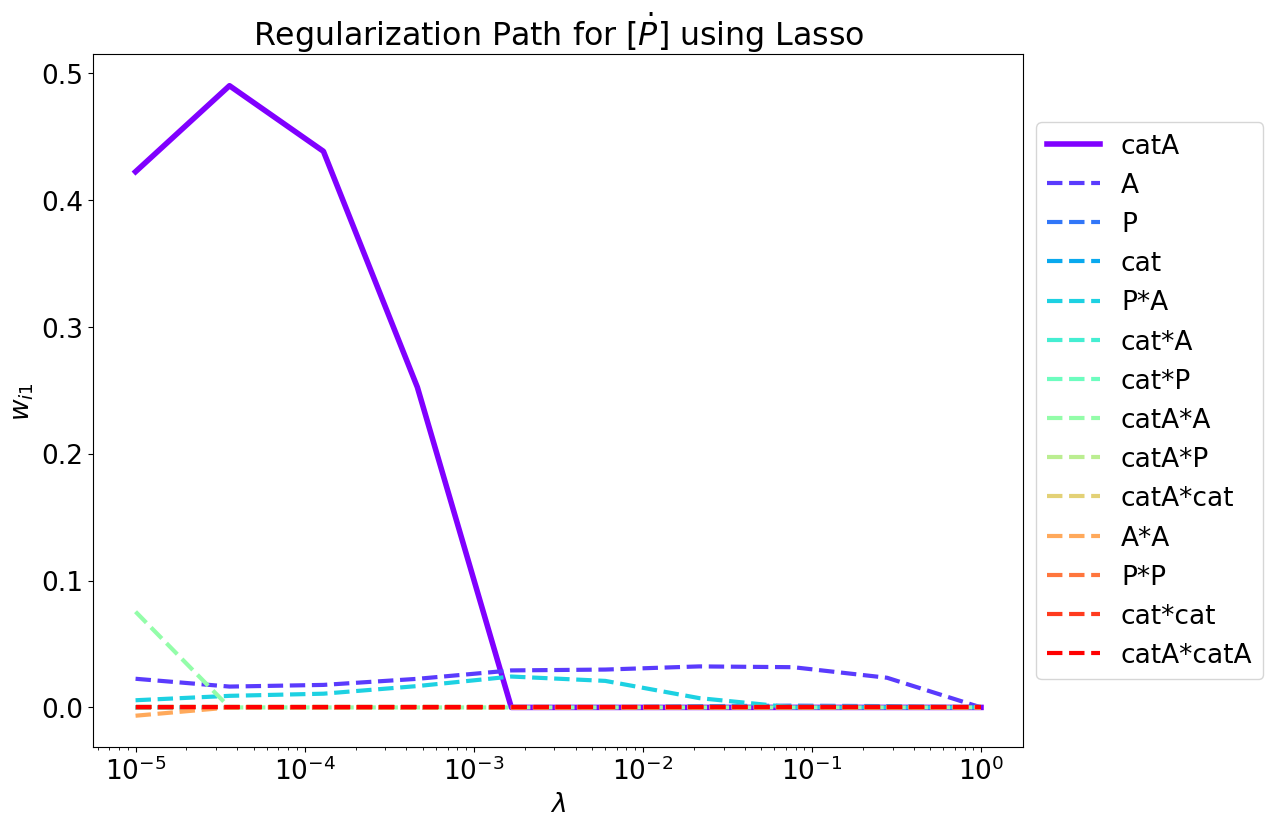

In [42]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 1, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{P}]$ using Lasso")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ using Lasso')

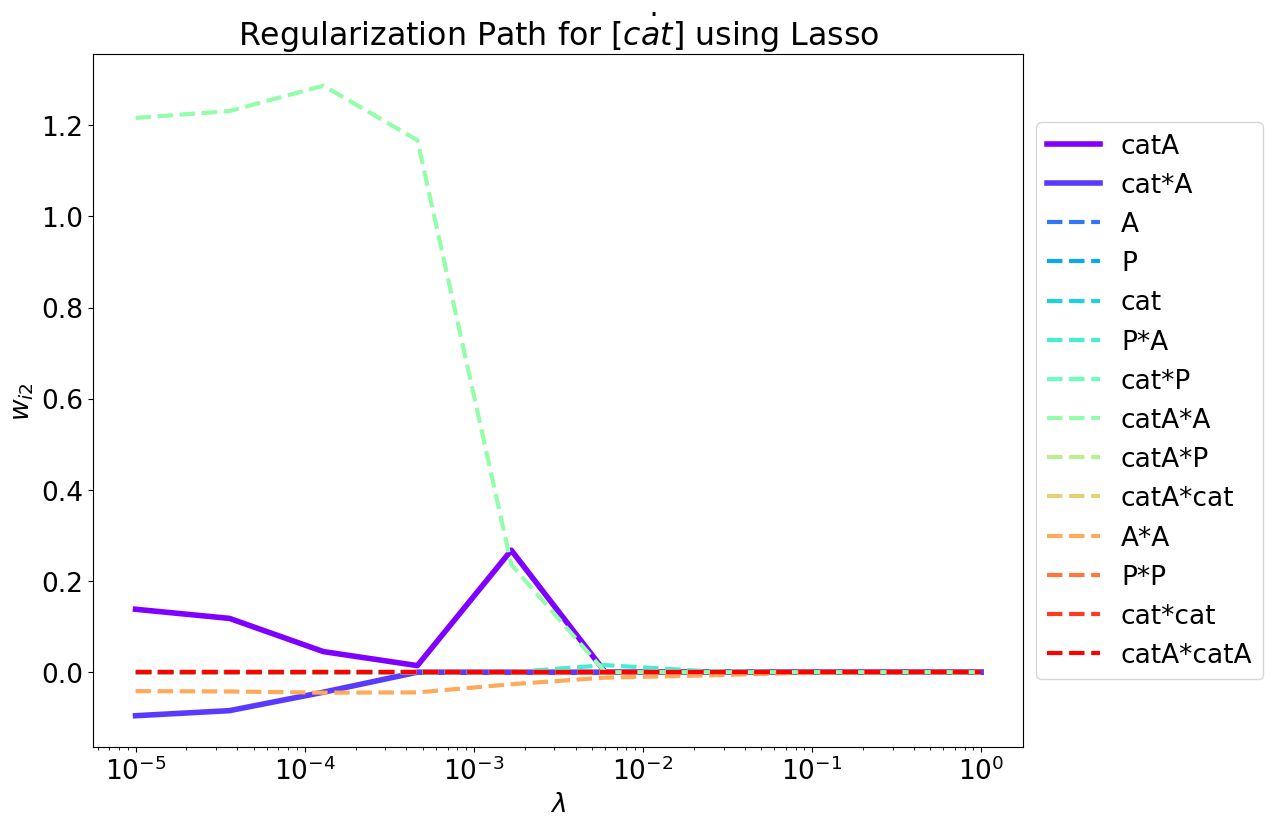

In [43]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 2, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{cat}]$ using Lasso")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ using Lasso')

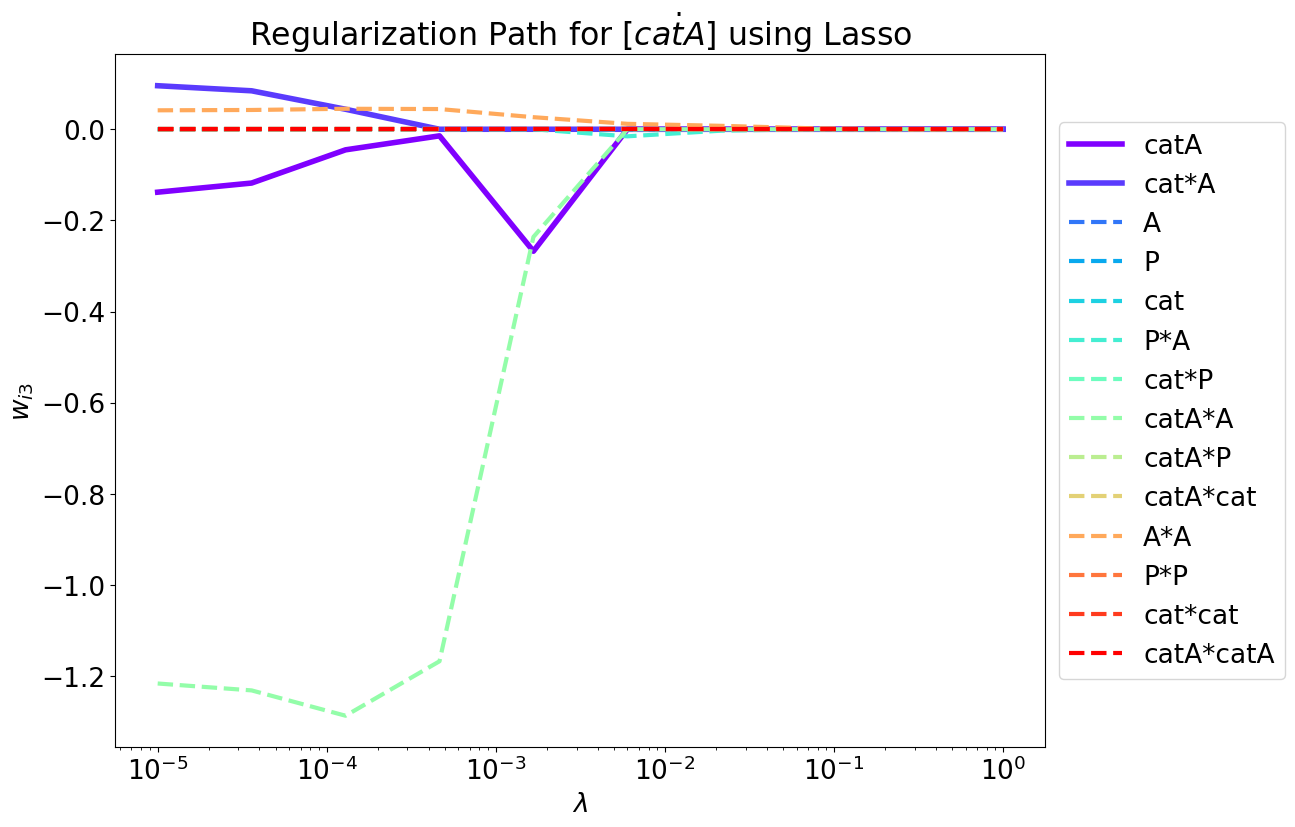

In [44]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 3, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{catA}]$ using Lasso")

In [45]:
lambd = 1e-4
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, 100, rtol, integration, t_eq)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

-0.49[cat*A]+0.42[catA*A]-0.02[A*A]
______
+0.02[A]+0.45[catA]+0.01[P*A]
______
+0.07[catA]-0.06[cat*A]+1.27[catA*A]-0.04[A*A]
______
-0.07[catA]+0.06[cat*A]-1.27[catA*A]+0.04[A*A]
______
sparsity: 14
-2.5592634416264593e-05*P-0.49206841206481045*cat*A+0.42310908968696304*catA*A-0.01650687117302031*A*A
______
+0.017329080058149378*A+0.4544881515575372*catA+0.010296020542716451*P*A-1.2187727181300954e-05*P*P
______
+0.06813362026774636*catA-0.056644658877690095*cat*A+1.2692900860358654*catA*A-0.04410856574926077*A*A+0.0001530375695724113*P*P
______
-0.06813380098850155*catA+0.05664473685267182*cat*A-1.2692898399872667*catA*A+0.044108558050593584*A*A-0.00015303760230471922*P*P
______
absolute residual 0.0804137907932049
relative residual 0.32340013385676764
absolute residual 0.02480102227860922
relative residual 0.09974226865281242
absolute residual 0.05021731802675329
relative residual 0.006144521054936874
absolute residual 3.7690067947796537
relative residual 1.9158498329623899


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.321634,0.017112,0.004306,0.997828,56
STLSQ $lpha$=0.5,0.321634,0.017112,0.004306,0.997828,56
"STLSQ, $lpha$ = 0.4",0.321634,0.017112,0.004306,0.997828,56
"Lasso_cvxp, $\lambda$ = 0.0001",0.323400,0.099742,0.006145,1.915850,14


In [46]:
lambd = 1e-3
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, 100, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

-0.40[cat*A]-0.01[A*A]
______
+0.03[A]+0.02[P*A]
______
+0.13[catA]+0.75[catA*A]-0.04[A*A]
______
-0.13[catA]-0.75[catA*A]+0.04[A*A]
______
sparsity: 10
-0.0005656705058830799*P-0.4024988217603705*cat*A-0.012268208118774233*A*A
______
+0.029050029667638064*A+0.024924484872540814*P*A-0.0002470726652210528*P*P
______
+0.12715619569440578*catA+0.7529210869799504*catA*A-0.036387118691236425*A*A-0.00038600181548691163*P*P
______
-0.12715619398485714*catA-0.7529210923338548*catA*A+0.03638711877749612*A*A+0.0003860018124052311*P*P
______
absolute residual 0.10292440577907595
relative residual 0.4037531514194262
absolute residual 0.07030113702119964
relative residual 0.2757781830832648
absolute residual 0.1838432220733999
relative residual 0.02291002374116044
absolute residual 3.5369674321803077
relative residual 3.064190788010577


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.321634,0.017112,0.004306,0.997828,56
STLSQ $lpha$=0.5,0.321634,0.017112,0.004306,0.997828,56
"STLSQ, $lpha$ = 0.4",0.321634,0.017112,0.004306,0.997828,56
"Lasso_cvxp, $\lambda$ = 0.0001",0.323400,0.099742,0.006145,1.915850,14
"Lasso_cvxp, $\lambda$ = 0.001",0.403753,0.275778,0.022910,3.064191,10


In [47]:
lambd = 1e-5
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, 100, rtol, integration, t_eq)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

-0.50[cat*A]+0.47[catA*A]-0.02[A*A]
______
+0.02[A]+0.42[catA]+0.08[catA*A]
______
+0.14[catA]-0.10[cat*A]+1.22[catA*A]-0.04[A*A]
______
-0.14[catA]+0.10[cat*A]-1.22[catA*A]+0.04[A*A]
______
sparsity: 14
-0.5007562013985875*cat*A+0.46637946485320475*catA*A-0.016979259545661957*A*A+2.6030414863086894e-05*P*P
______
+0.02258289269008243*A+4.5431828144774306e-05*P+0.42222231156577356*catA+0.005650984589064893*P*A+0.0754356482851563*catA*A-0.006542515906713257*A*A
______
+0.13808875106970833*catA-0.09552871096436966*cat*A+1.2161990140335854*catA*A-0.04157128642381307*A*A+0.00018377629358716518*P*P
______
-0.1380880725880562*catA+0.09552841386425541*cat*A-1.2161999562747026*catA*A+0.041571315947395104*A*A-0.00018377665169577655*P*P
______
absolute residual 0.07986186472482408
relative residual 0.3213111002627619
absolute residual 0.022638078028295438
relative residual 0.09108059001839046
absolute residual 0.039579372535343715
relative residual 0.004841597527446813
absolute residual 3.652184

,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.321634,0.017112,0.004306,0.997828,56
STLSQ $lpha$=0.5,0.321634,0.017112,0.004306,0.997828,56
"STLSQ, $lpha$ = 0.4",0.321634,0.017112,0.004306,0.997828,56
"Lasso_cvxp, $\lambda$ = 0.0001",0.323400,0.099742,0.006145,1.915850,14
"Lasso_cvxp, $\lambda$ = 0.001",0.403753,0.275778,0.022910,3.064191,10
"Lasso_cvxp, $\lambda$ = 1e-05",0.321311,0.091081,0.004842,1.906106,14


In [48]:
lambd

1e-05

# pySINDy

In [49]:
import pysindy as ps

In [50]:
def make_library(mechType):
    if mechType == 'A1r':
        feature_names = ['A', 'P', 'cat', 'catA']
    elif mechType == 'A1ra':
        feature_names = ['A', 'P', 'cat', 'catact', 'catactA']
    elif mechType == 'A2r':
        feature_names = ['A', 'P', 'cat', 'catA', 'B']
    library_functions = [
        lambda x : x,
        lambda x : x * x, 
        lambda x,y : x*y
    ]
    library_function_names = [
        lambda x : x ,
        lambda x :  x + '*' + x,
        lambda x,y : x + '*' + y 
    ]
    custom_library = ps.CustomLibrary(
         library_functions=library_functions, function_names=library_function_names,  
    )
    
    return [custom_library, feature_names]

In [51]:
opt = ps.STLSQ(threshold = 0.008, alpha=0.05) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()

(A)' = 0.294 A + 0.003 cat + -1.094 catA + -0.278 A*A + -0.218 A*P + -0.760 A*cat + 0.789 A*catA
(P)' = 0.029 A + 0.024 A*P
(cat)' = 0.004 cat + -1.116 catA + 0.067 A*A + 0.156 A*P + -1.078 A*cat + 1.222 A*catA
(catA)' = -0.004 cat + 1.116 catA + -0.067 A*A + -0.156 A*P + 1.078 A*cat + -1.222 A*catA


In [52]:
W_sindy = model_custom.coefficients()

In [53]:
mechanisms.print_equation(labels, W_sindy, 1e-5)

+0.29[A]+0.00[cat]-1.09[catA]-0.28[P*A]-0.22[catA*P]-0.76[catA*cat]+0.79[A*A]
______
+0.03[A]+0.02[catA*P]
______
+0.00[cat]-1.12[catA]+0.07[P*A]+0.16[catA*P]-1.08[catA*cat]+1.22[A*A]
______
-0.00[cat]+1.12[catA]-0.07[P*A]-0.16[catA*P]+1.08[catA*cat]-1.22[A*A]
______
sparsity: 21


21

In [54]:
W_sindy_arr = []
lambdas = np.linspace(0, 0.05, 100)
W_ridge_arr = []
for lambd in lambdas: 
    opt = ps.STLSQ(threshold = lambd, alpha=0.05) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.0101010101010101) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.010606060606060607) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.011111111111111112) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.011616161616161616) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pys

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.03888888888888889) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.03939393939393939) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.0398989898989899) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.0404040404040404) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{A}$ equation using SINDy')

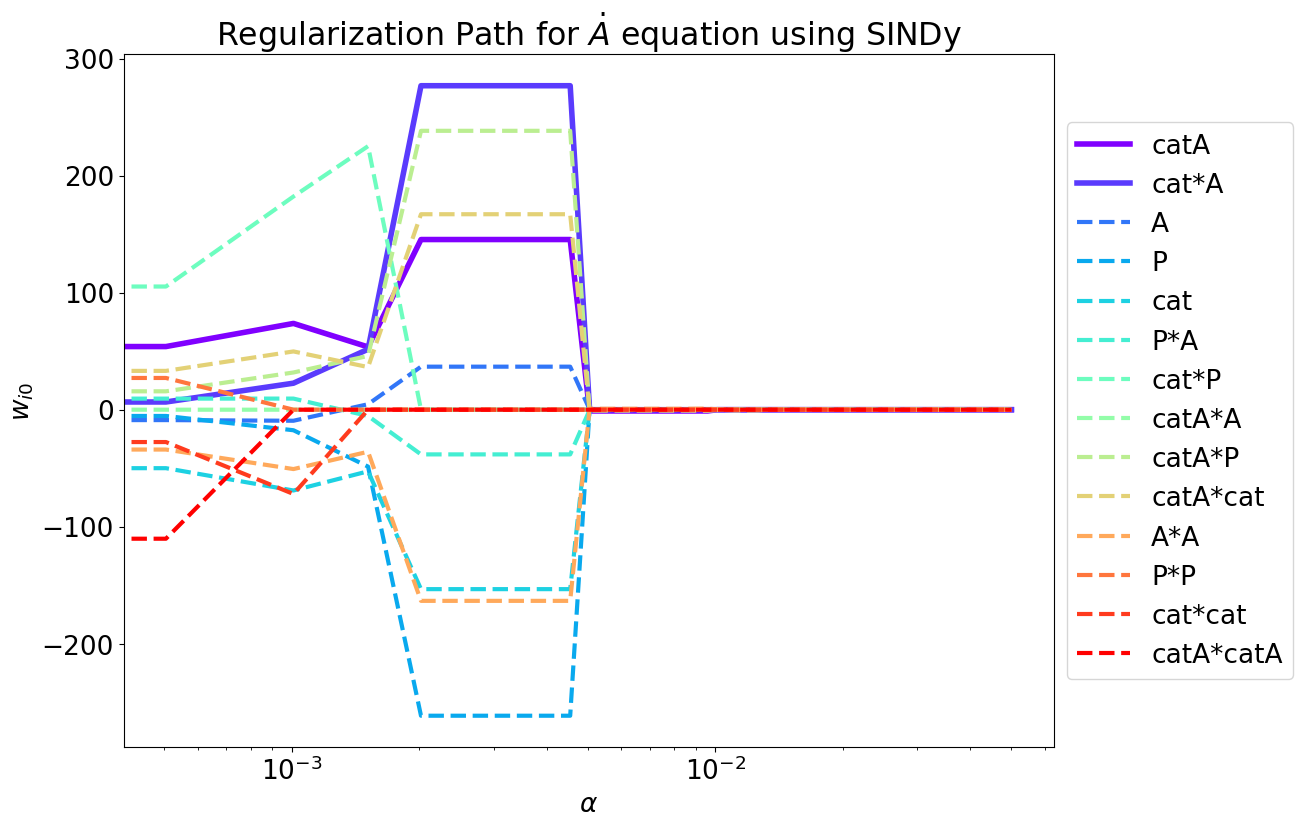

In [55]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $\dot{A}$ equation using SINDy")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{P}$ equation using SINDy')

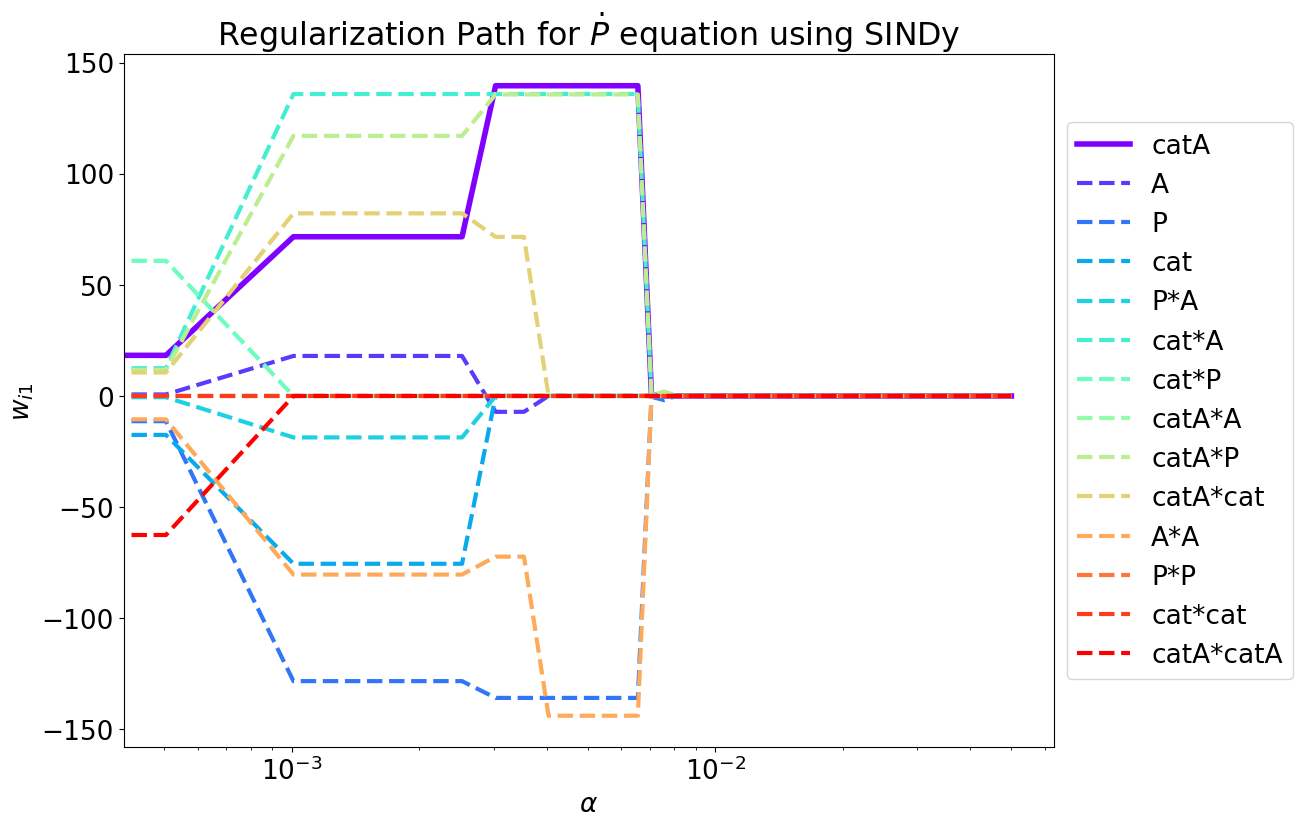

In [56]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $\dot{P}$ equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{cat}$ equation using SINDy')

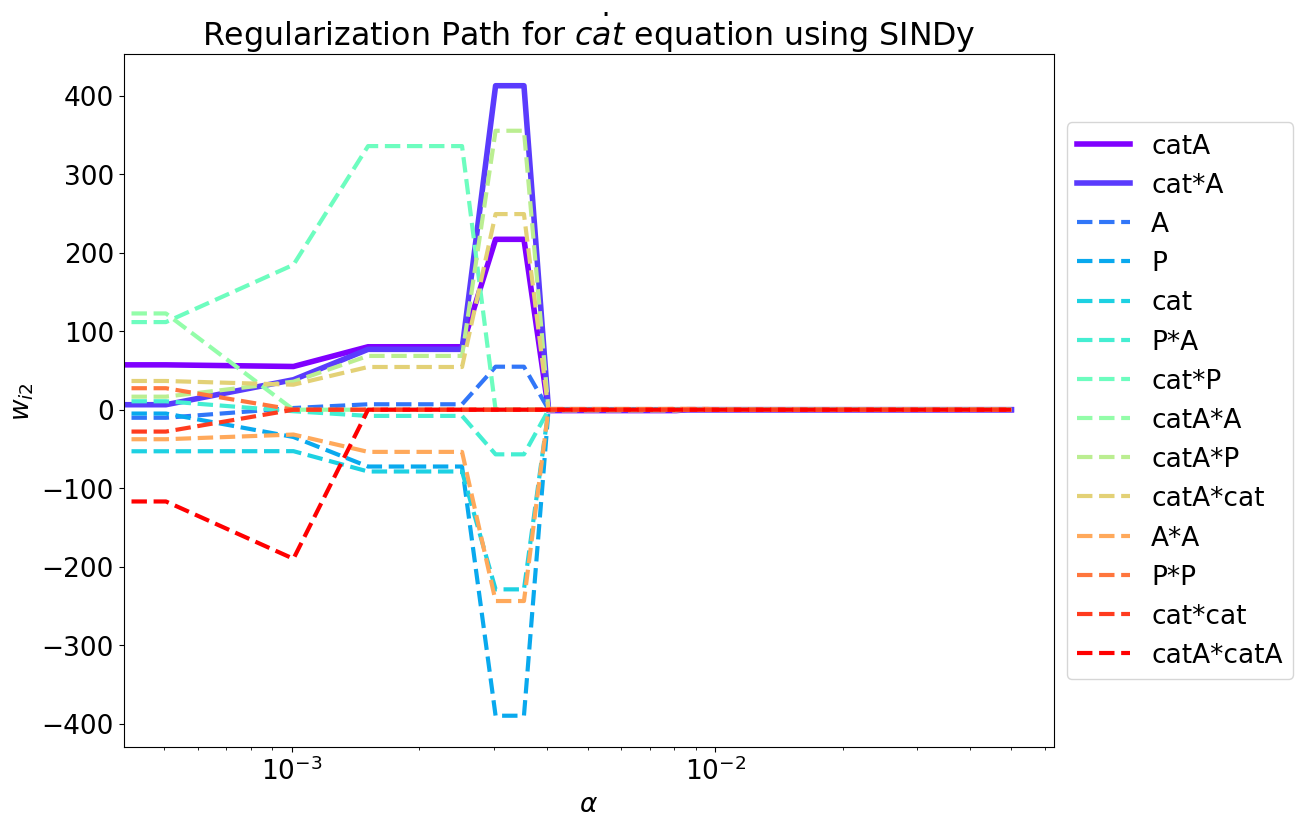

In [57]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $\dot{cat}$ equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{catA}$ equation using SINDy')

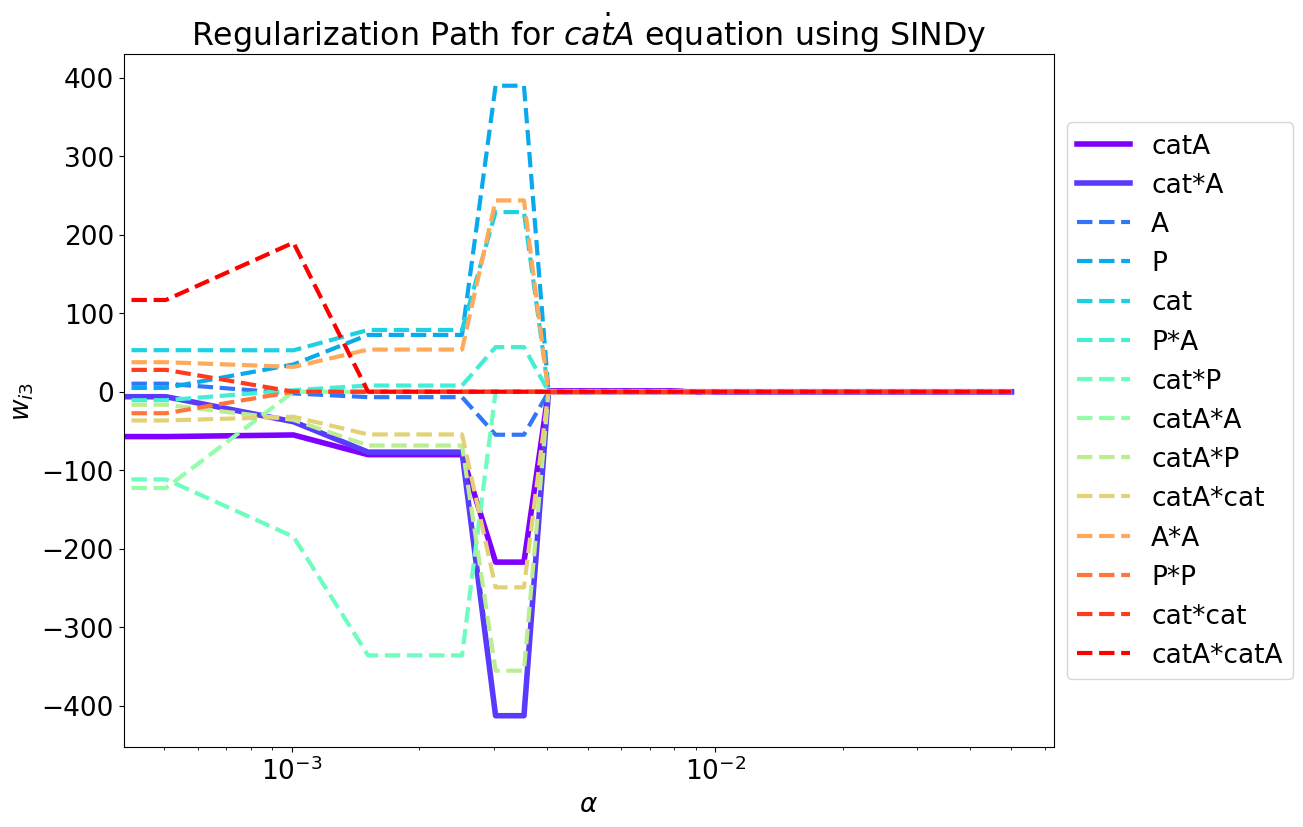

In [58]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $\dot{catA}$ equation using SINDy")

In [59]:
W_sindy_arr = []
alphas = np.linspace(0, 0.2, 100)
W_ridge_arr = []
for alph in alphas: 
    opt = ps.STLSQ(threshold = 0.015, alpha=alph) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parame

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parame

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.015) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parame

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

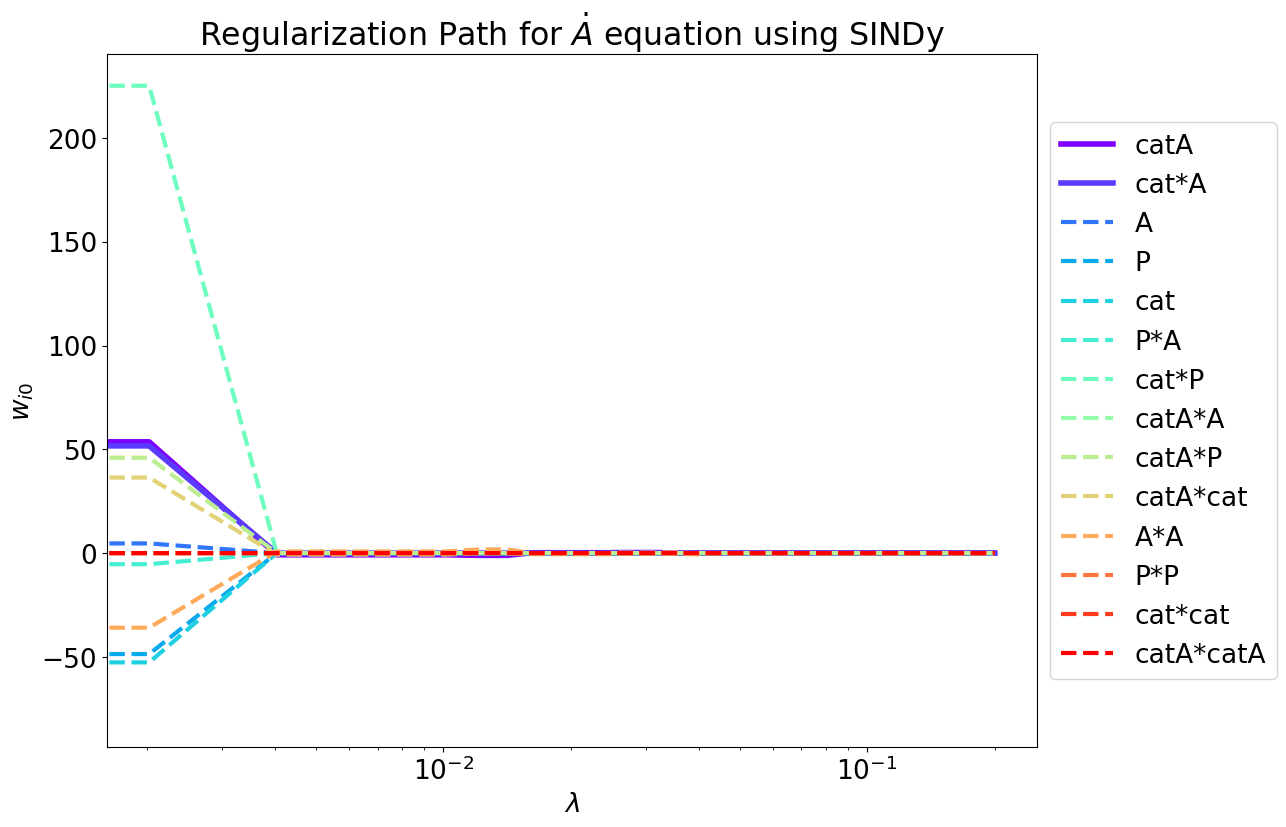

In [60]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $\dot{A}$ equation using SINDy")
plt.xlabel('$\lambda$')

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

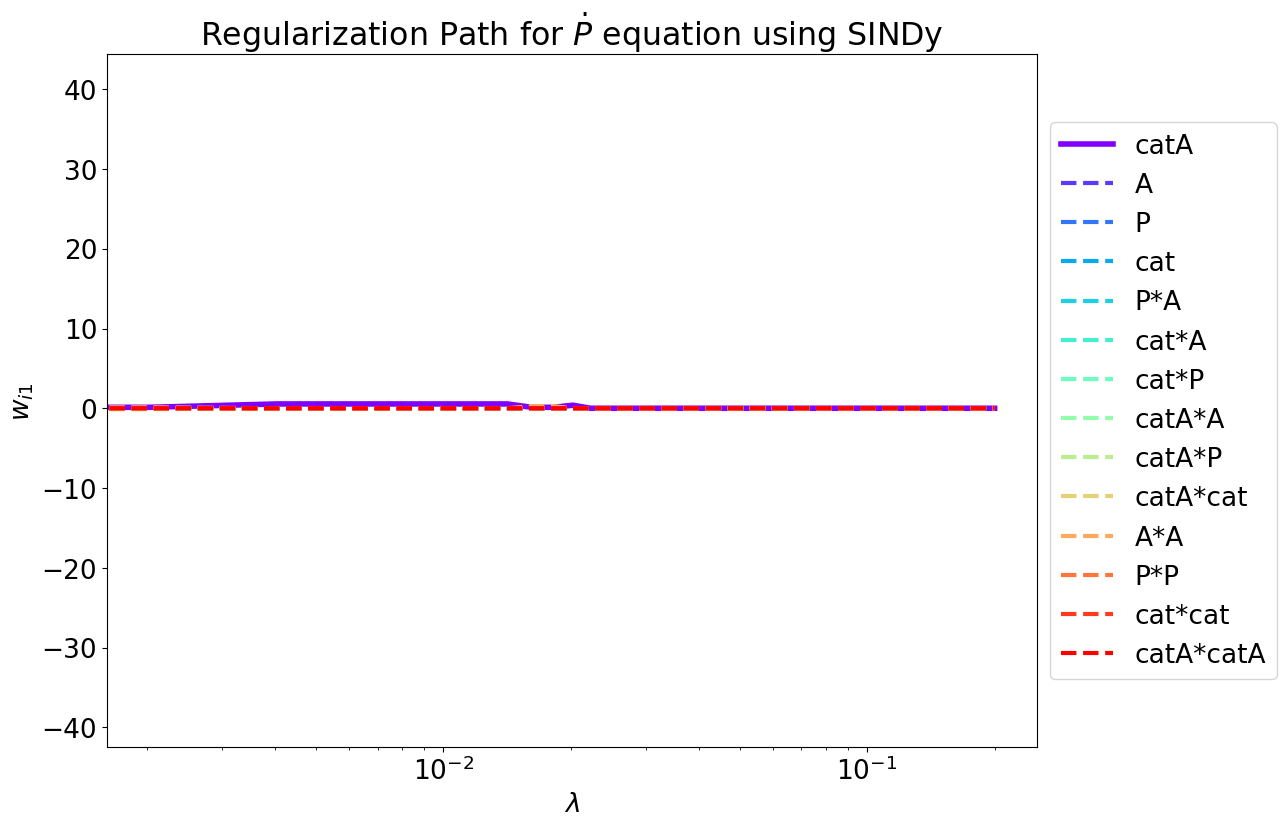

In [61]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $\dot{P}$ equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

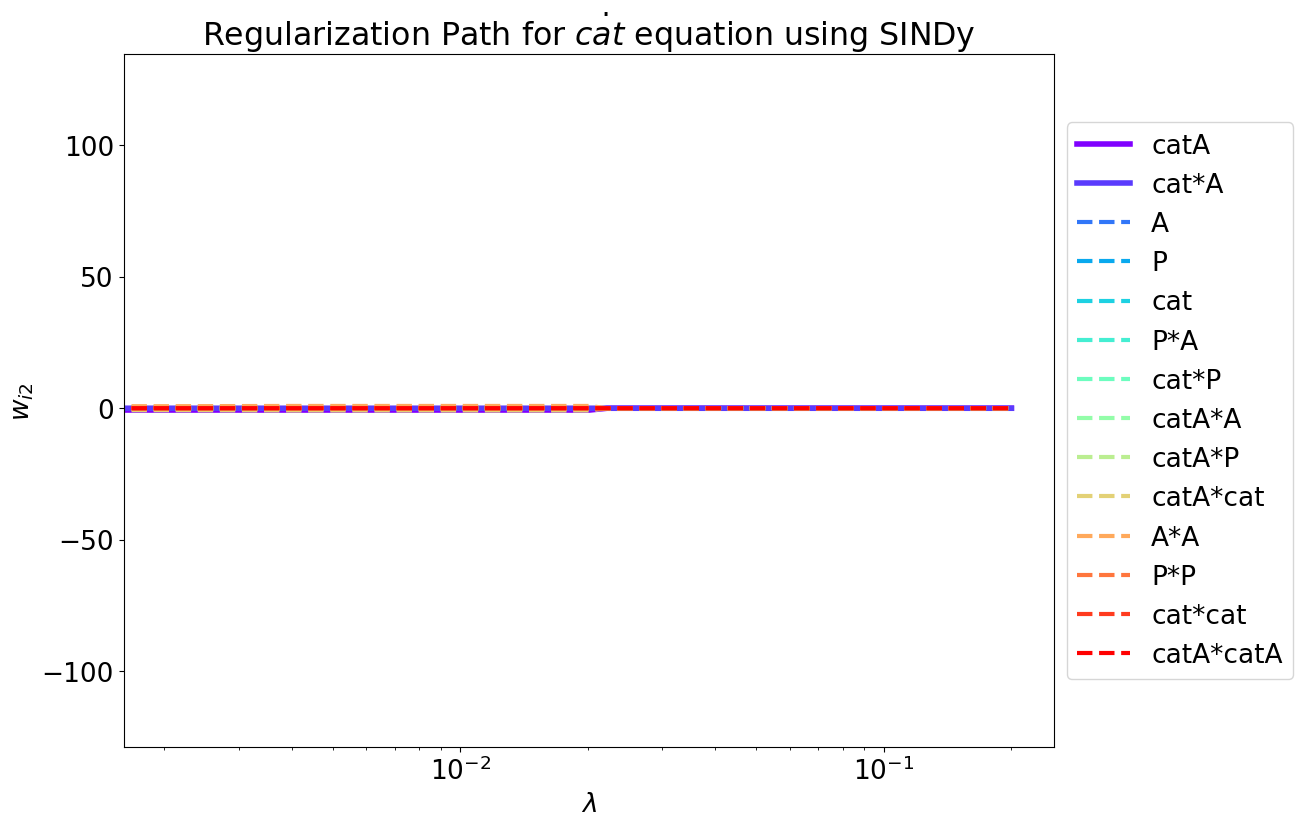

In [62]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $\dot{cat}$ equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

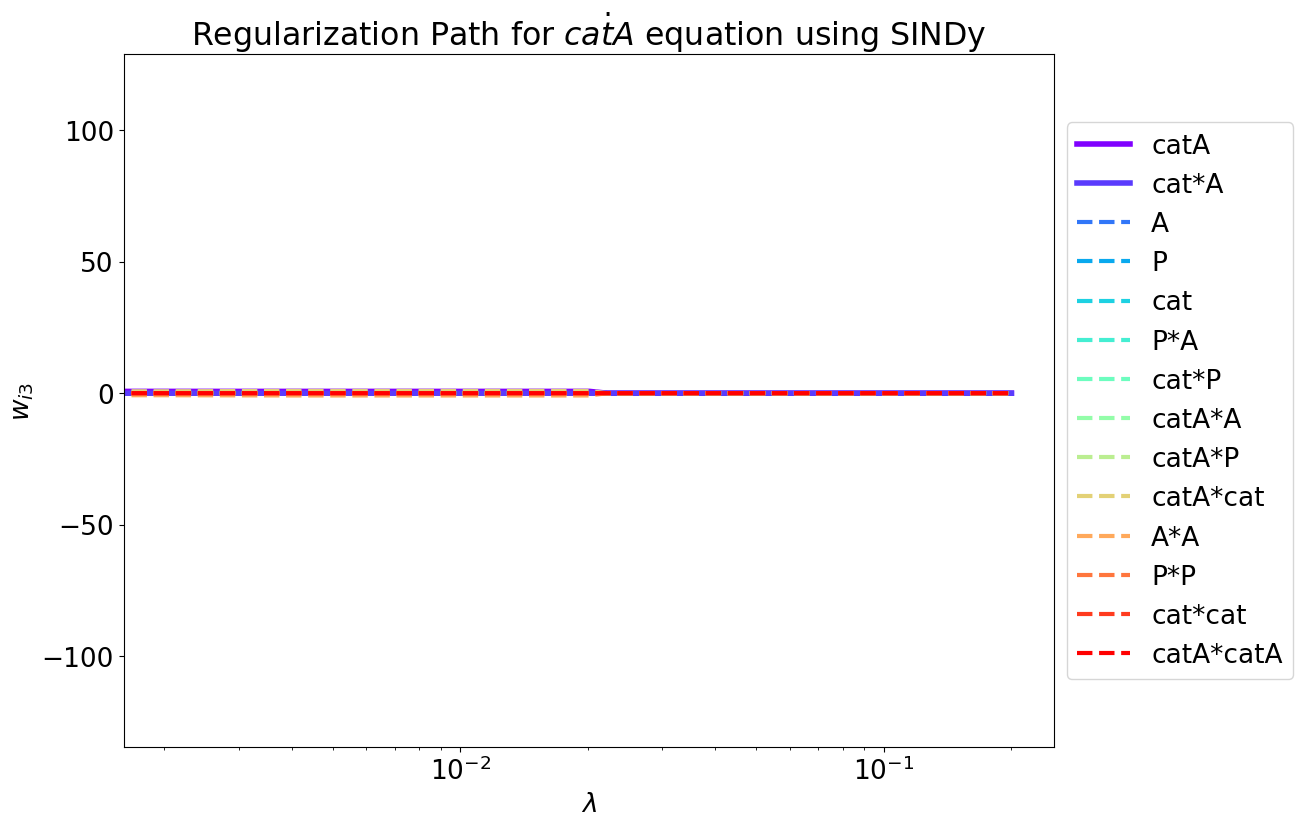

In [63]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $\dot{catA}$ equation using SINDy")
plt.xlabel('$\lambda$')

In [64]:
opt = ps.STLSQ(threshold = 0.05, alpha=0.05) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()

(A)' = 0.000
(P)' = 0.000
(cat)' = 0.000
(catA)' = 0.000


/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:185: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)


In [65]:
mechanisms.print_equation(labels, W_sindy, 1e-5)


______

______

______

______
sparsity: 0


0

In [66]:
_, er_w = mechanisms.get_residual(W_sindy, W0)

absolute residual 3.605551275463989
relative residual inf


/Users/apple/Dropbox/Ayana-Igor-Stefan/initial experiments/scripts/mechanisms.py:455: RuntimeWarning: divide by zero encountered in double_scalars
  relres = norm(YD -  Y_gt)/norm(YD)
